In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [26]:
timestamp = "2022_1025_1733_36"

In [71]:
timestamp = "2022_1025_1721_42"

In [256]:
timestamp = "2022_1026_1049_26"

In [329]:
timestamp = "2022_1026_1508_45"

## Random model

In [294]:
from peaknet.methods.unet import UNet
from peaknet.model        import ConfigPeakFinderModel, PeakFinderModel

In [330]:
base_channels = 8
pos_weight    = 20.0
method = UNet( in_channels = 1, out_channels = 1, base_channels = base_channels )
config_peakfinder = ConfigPeakFinderModel( method = method, 
                                           pos_weight = pos_weight, )
model = PeakFinderModel(config_peakfinder)
model.init_params()

In [331]:
model.init_params(from_timestamp = timestamp)   # Run this will load a trained model

In [332]:
# Load model to gpus if available...
device = torch.cuda.current_device() if torch.cuda.is_available() else 'cpu'
model  = torch.nn.DataParallel(model.method).to(device)

## Define hooks

In [334]:
# Define hooks...
activation_dict = {}
preactivation_dict = {}
def get_activation(name, tag = ''):
    if tag not in preactivation_dict: preactivation_dict[tag] = {}
    if tag not in activation_dict: activation_dict[tag] = {}
    def hook(model, input, output):
        preactivation_dict[tag][name] = input
        activation_dict[tag][name] = output
    return hook


# Define what layer you want to check...
for name, layer in model.named_modules():
    if isinstance(layer, torch.nn.ReLU):
        layer.register_forward_hook(get_activation(name, 'relu'))

    if "final_conv" in name:
        layer.register_forward_hook(get_activation(name, 'final_conv'))

## Load an image

The model predicts many false peaks for a test image.  Why is that?

In [335]:
test_img = torch.load('test.img')
test_img = torch.tensor(test_img).to(device)
test_img = test_img[None, None]
test_img += test_img.mean()

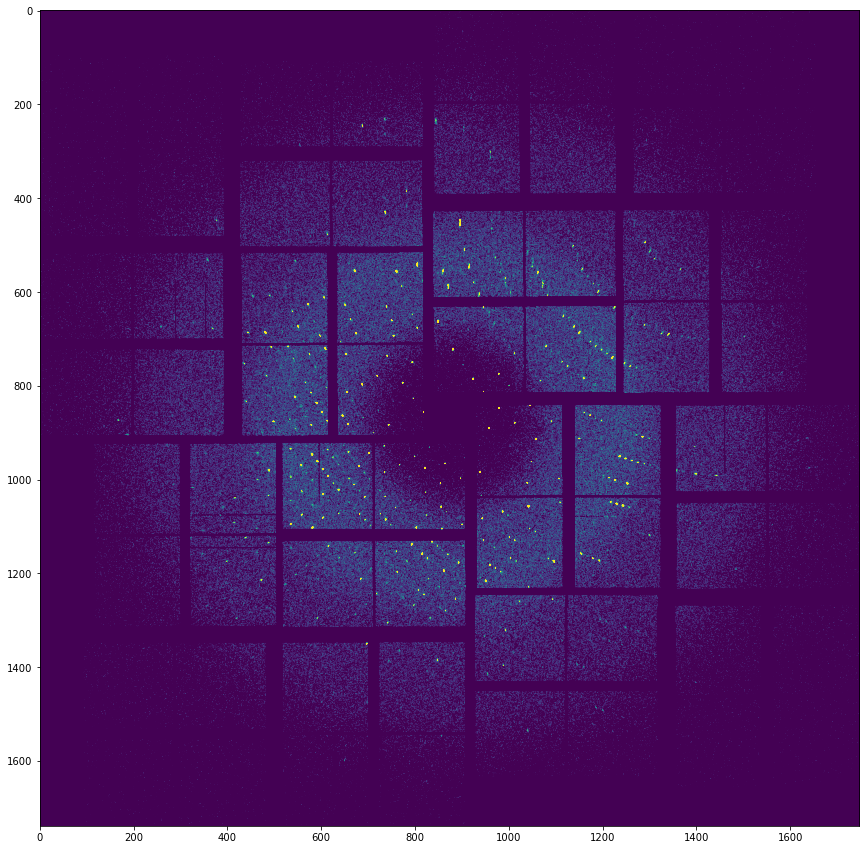

In [336]:
plt.figure(figsize=(20,15))
data = test_img[0, 0].cpu().detach().numpy()
vmin = data.mean()
#data = data[1200:1400, 50:250]
vmax = vmin + 4 * data.std()
plt.imshow(data, vmin = vmin, vmax = vmax)

In [337]:
model.eval()
with torch.no_grad():
    fmap = model.forward(test_img)

In [338]:
fmap.shape

torch.Size([1, 1, 1728, 1744])

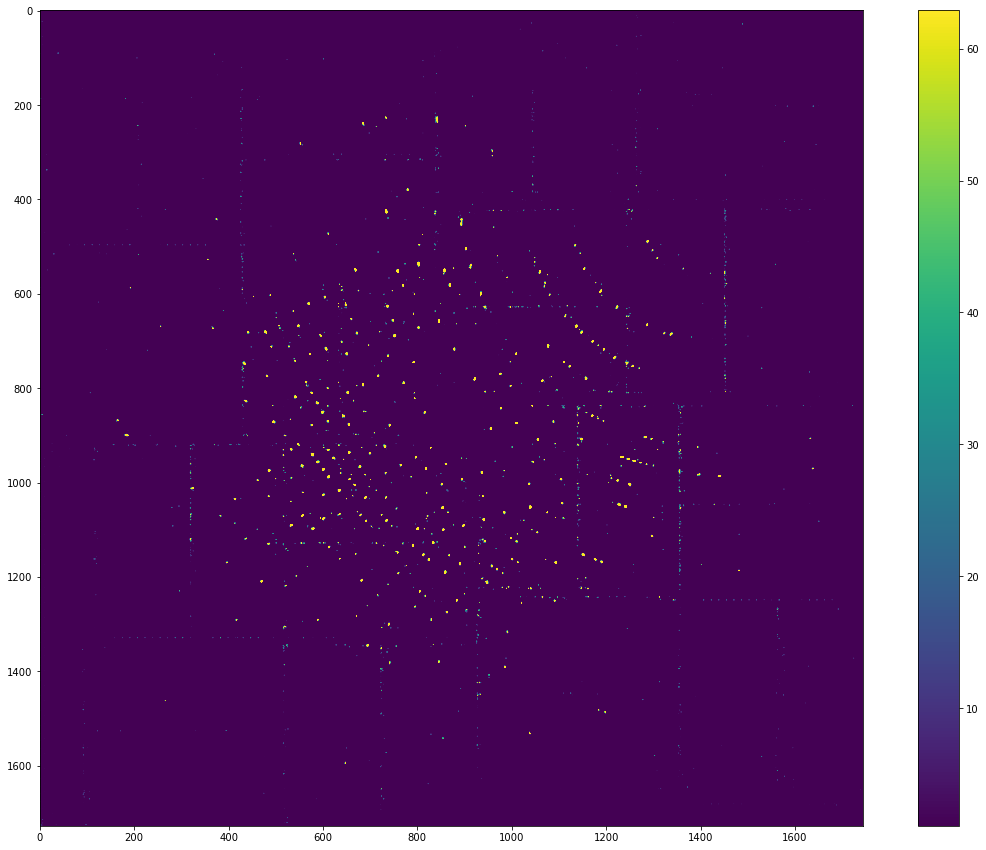

In [339]:
plt.figure(figsize=(20,15))
data = fmap[0, 0].relu().cpu().detach().numpy()
vmin = data.mean()
vmax = vmin + data.std()
plt.imshow(data, vmin = vmin, vmax = vmax)
plt.colorbar()

## Activation

In [340]:
activation_dict['final_conv'].keys()

dict_keys(['module.final_conv'])

In [341]:
amap = activation_dict['final_conv']['module.final_conv']
amap.shape

torch.Size([1, 1, 1728, 1744])

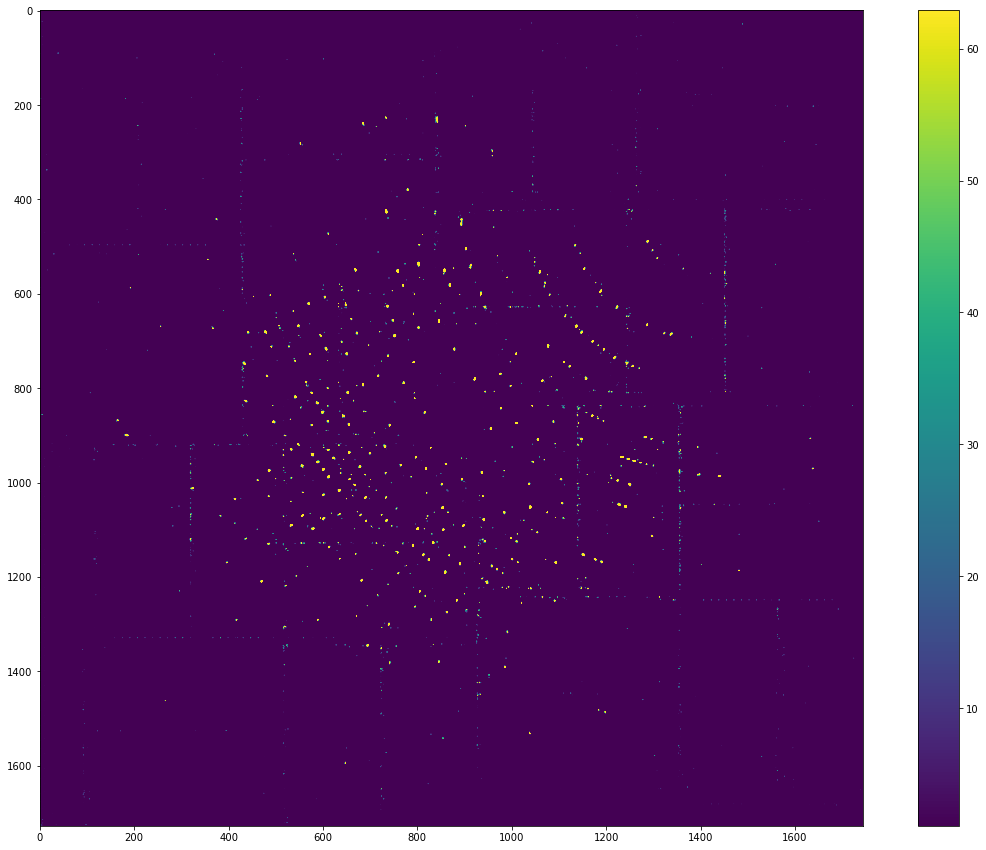

In [375]:
plt.figure(figsize=(20,15))
data = amap[0, 0].relu().cpu().detach().numpy()
vmin = data.mean()
vmax = vmin + data.std()
plt.imshow(data, vmin = vmin, vmax = vmax)
plt.colorbar()

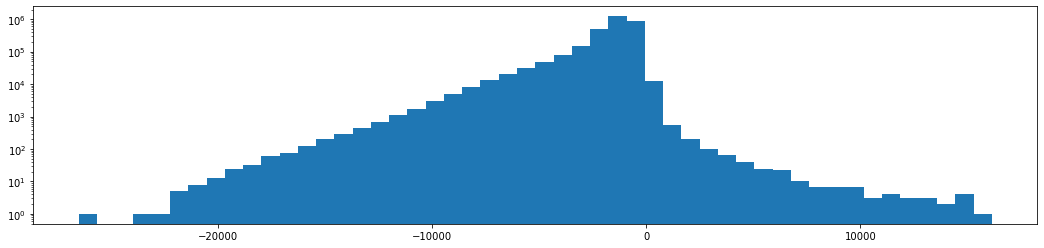

In [359]:
plt.figure(figsize=(18,4))
plt.hist(data.reshape(-1), bins = 50)
plt.yscale('log')
#plt.xlim(-2e2,3e2)

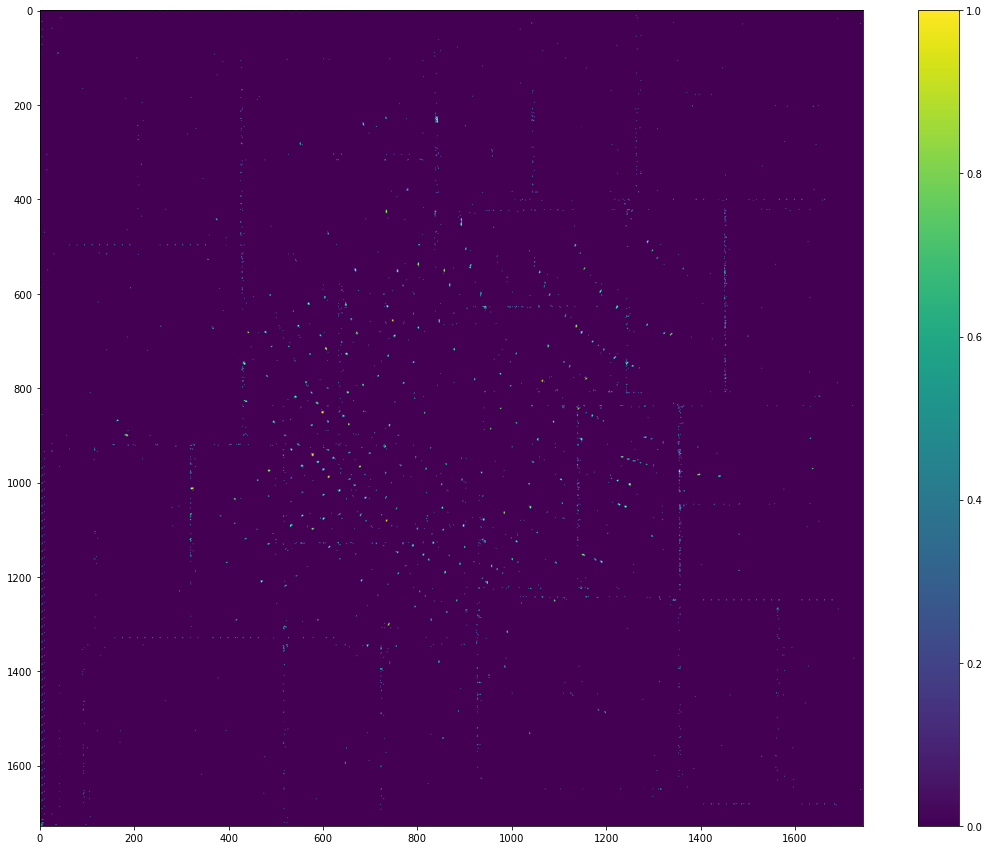

In [362]:
plt.figure(figsize=(20,15))
data = amap[0, 0].sigmoid().cpu().detach().numpy()
vmin = data.mean()
vmax = vmin + data.std()
plt.imshow(data, vmin = 0, vmax = 1)
plt.colorbar()

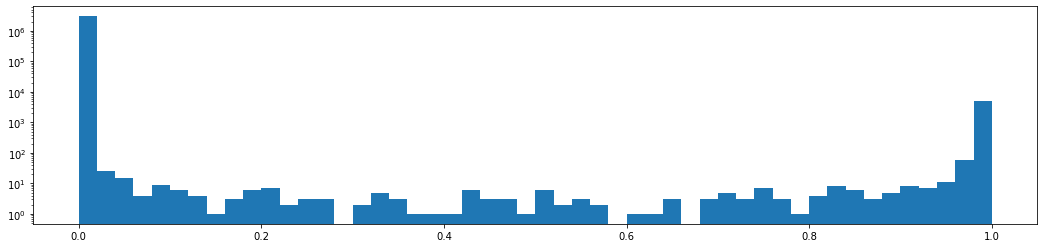

In [361]:
plt.figure(figsize=(18,4))
plt.hist(data.reshape(-1), bins = 50)
plt.yscale('log')
#plt.xlim(-2e2,3e2)

### Label it with boxes

In [345]:
from scipy import ndimage
import matplotlib.patches as mpatches

In [371]:
data = amap[0, 0].relu().cpu().detach().numpy()
threshold = data.mean() + 6 * data.std()
data[  data < threshold ] = 0.0
data[~(data < threshold)] = 1.0

# Put box on peaks...
structure = np.ones((3, 3), dtype=bool)
peak_labeled, num_peak = ndimage.label(data, structure)

# peak_area = [ np.sum(peak_labeled == i + 1) for i in range(num_peak) ]
# peak_pos_list = ndimage.center_of_mass(data, peak_labeled, [ i + 1 for i, area in enumerate(peak_area) if area > 1])
peak_pos_list = ndimage.maximum_position(data, peak_labeled, range(num_peak))

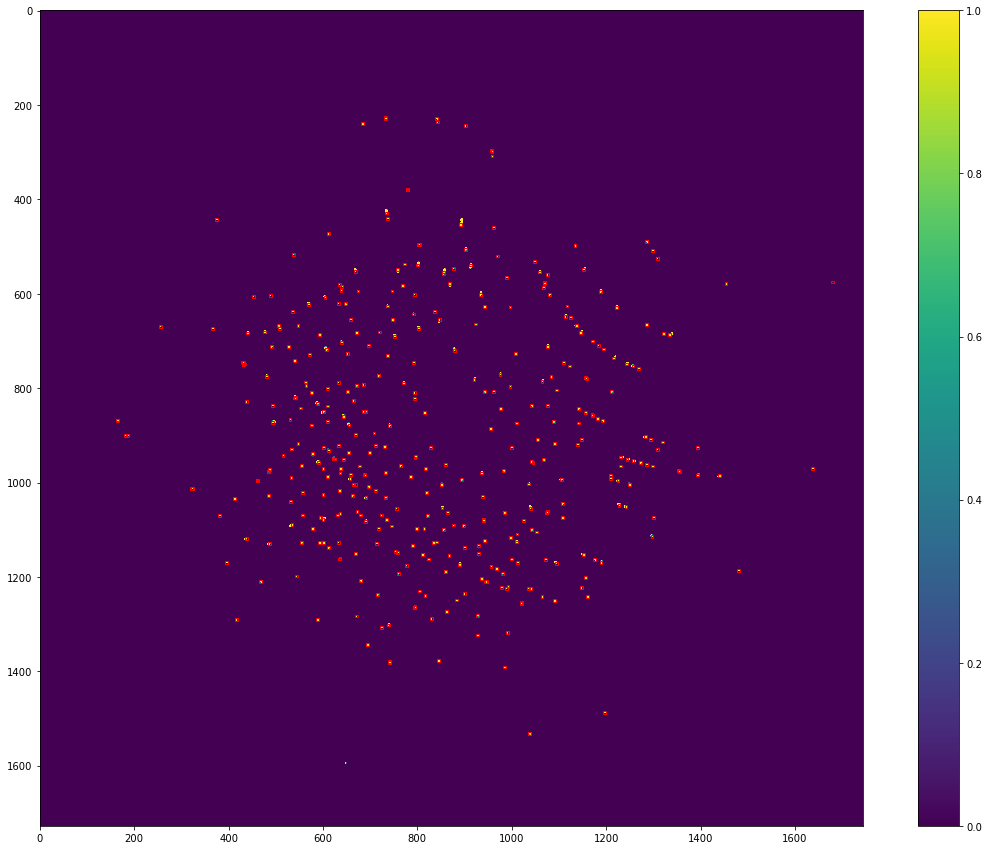

In [374]:
fig = plt.figure(figsize=(20,15))

data = amap[0, 0].relu().cpu().detach().numpy()
threshold = data.mean() + 6 * data.std()
data[  data < threshold ] = 0.0
data[~(data < threshold)] = 100.0
#data = data[900:1020, 520:690]
# vmin = data.mean()
# vmax = vmin + data.std()
# plt.imshow(data, vmin = vmin, vmax = vmax)
plt.imshow(data, vmin = 0, vmax = 1)
plt.colorbar()

# Add box
offset = 3
linewidth = 1
for y, x in peak_pos_list:
    if np.isnan(y) or np.isnan(x): continue

    x_bottom_left = x - offset
    y_bottom_left = y - offset

    ## x_bottom_left += 2
    ## y_bottom_left += 1

    rec_obj = mpatches.Rectangle((x_bottom_left, y_bottom_left), 
                                 2 * offset, 2 * offset, 
                                 linewidth = linewidth, 
                                 edgecolor = 'red', 
                                 facecolor='none')
    fig.gca().add_patch(rec_obj)

fig.gca().add_patch(rec_obj)
# plt.xlim(520,690)
# plt.ylim(900,1020)

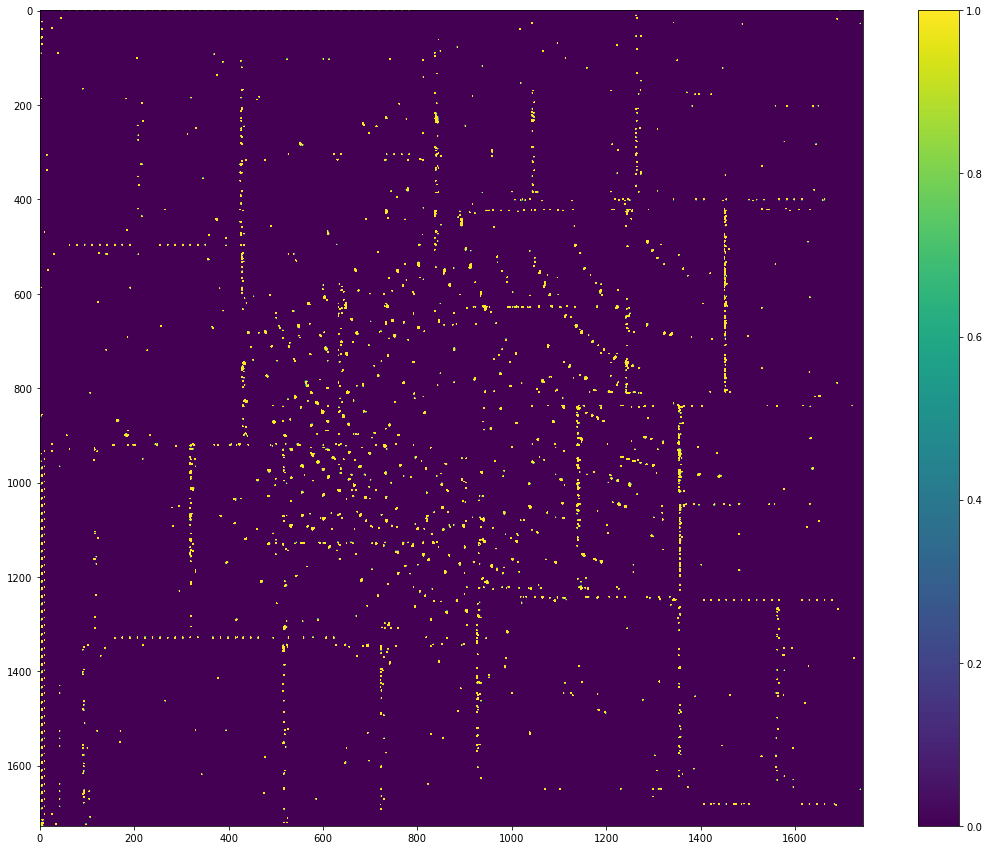

In [348]:
fig = plt.figure(figsize=(20,15))

data = amap[0, 0].sigmoid().cpu().detach().numpy()
threshold = data.mean() + 10 * data.std()
data[  data < threshold ] = 0.0
data[~(data < threshold)] = 100.0
#data = data[900:1020, 520:690]
# vmin = data.mean()
# vmax = vmin + data.std()
# plt.imshow(data, vmin = vmin, vmax = vmax)
plt.imshow(data, vmin = 0, vmax = 1)
plt.colorbar()


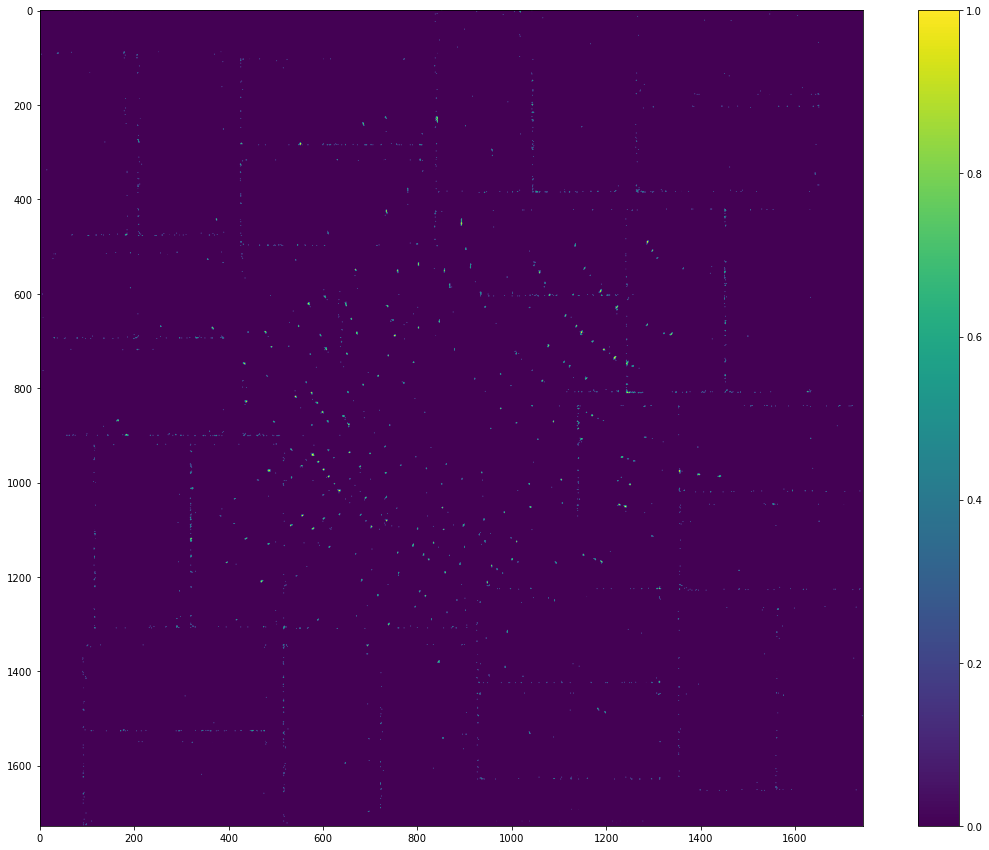

In [312]:
plt.figure(figsize=(20,15))
data = amap[0, 0].sigmoid().cpu().detach().numpy()
plt.imshow(data, vmin = 0, vmax = 1)
plt.colorbar()

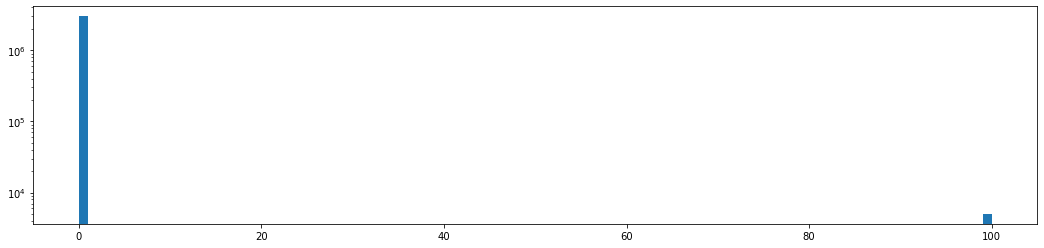

In [349]:
plt.figure(figsize=(18,4))
plt.hist(data.reshape(-1), bins = 100)
plt.yscale('log')
#plt.xlim(0, 1e3)

In [ ]:
plt.figure(figsize=(20,15))
data = amap[0, 0].cpu().detach().numpy()
threshold = 100
data[data < 1000] = 0
data[data > 1000] = 1
vmin = data.mean()
vmax = vmin + data.std()
plt.imshow(data, vmin = vmin, vmax = vmax)
plt.colorbar()

## Preactivation

In [161]:
preactivation_dict['final_conv'].keys()

dict_keys(['module.final_conv'])

In [162]:
preamap = preactivation_dict['final_conv']['module.final_conv']
preamap[0].shape

torch.Size([1, 8, 1728, 1744])

In [ ]:
for i in range(len(preamap[0][0])):
    plt.figure(figsize=(20,15))
    data = preamap[0][0, i].cpu().detach().numpy()
    vmin = data.mean()
    vmax = vmin + 1 * data.std()
    data = data[1200:1400, 50:250]
    plt.imshow(data, vmin = vmin, vmax = vmax)
    plt.colorbar()

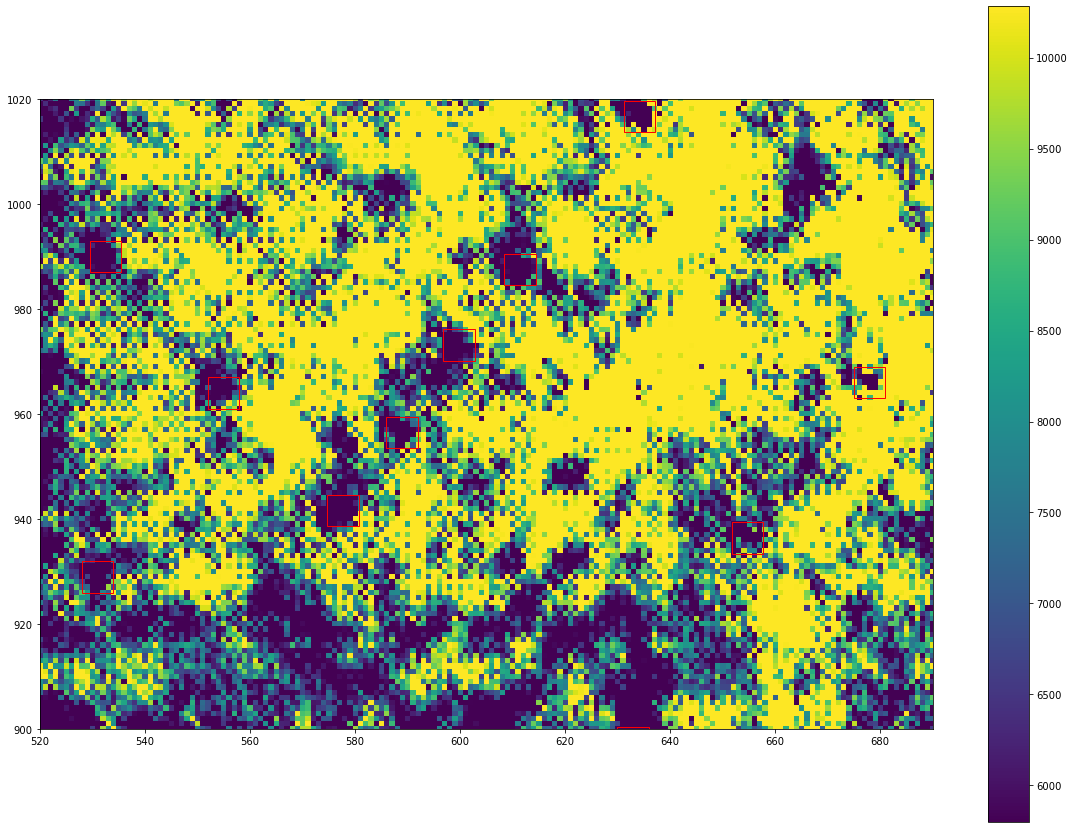

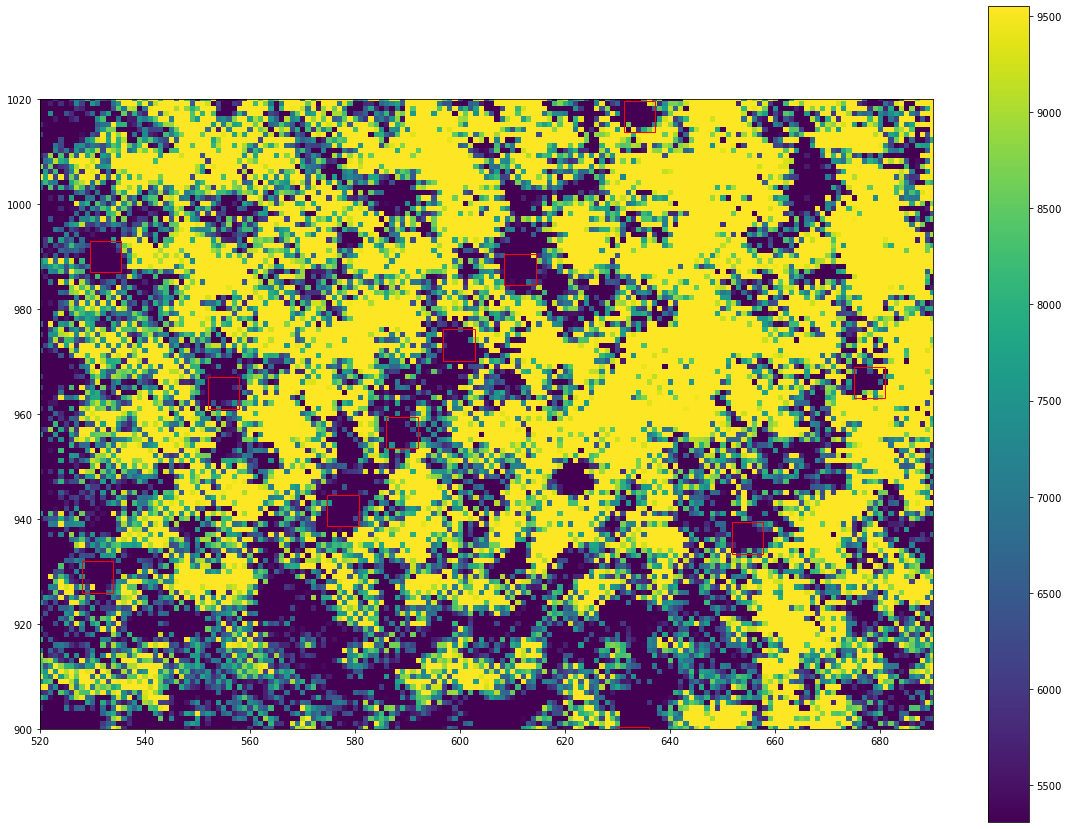

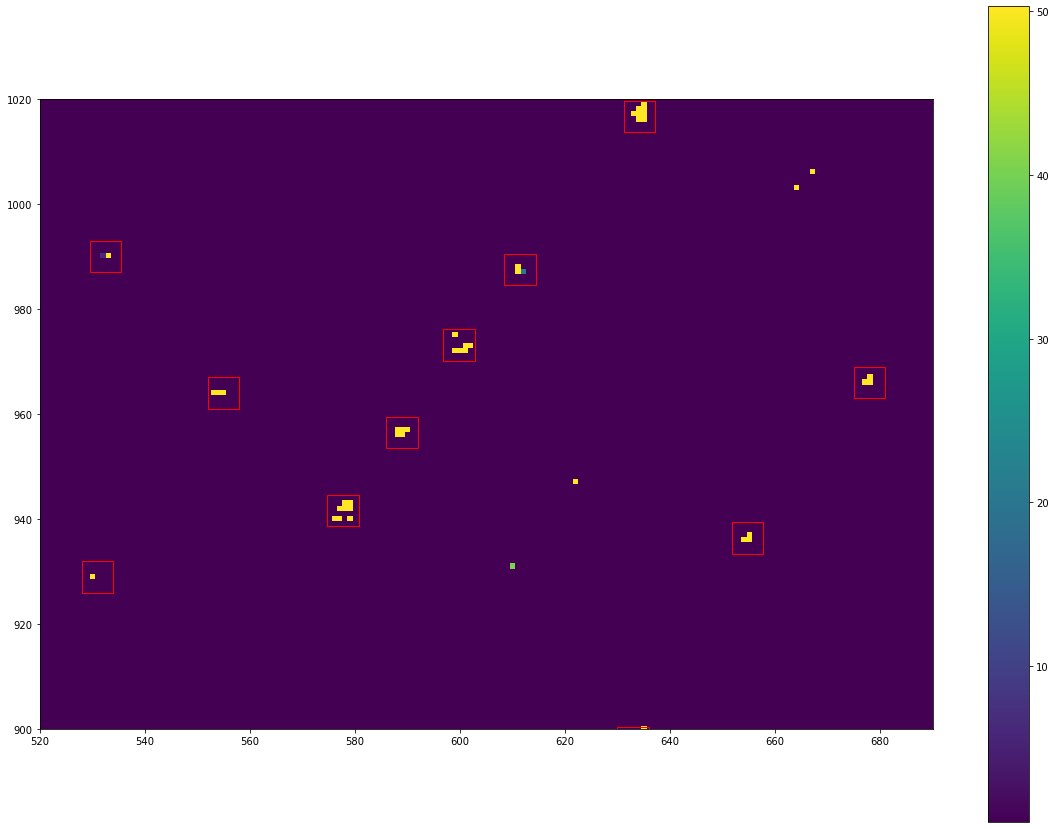

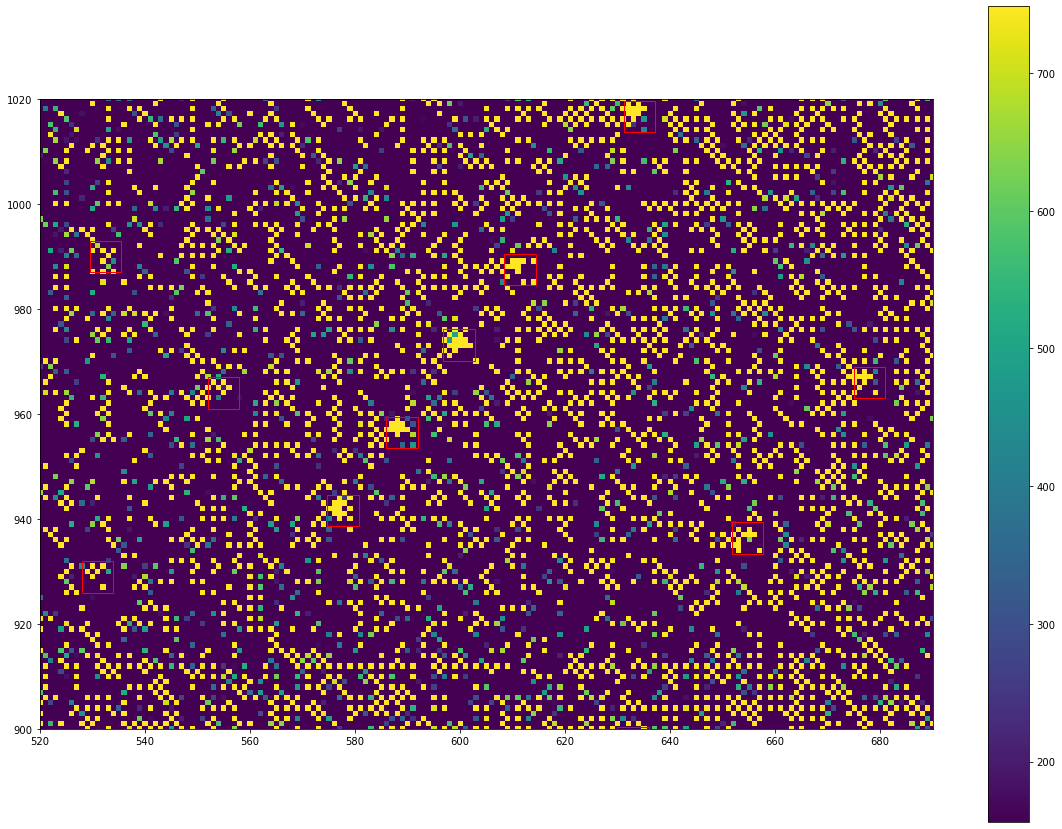

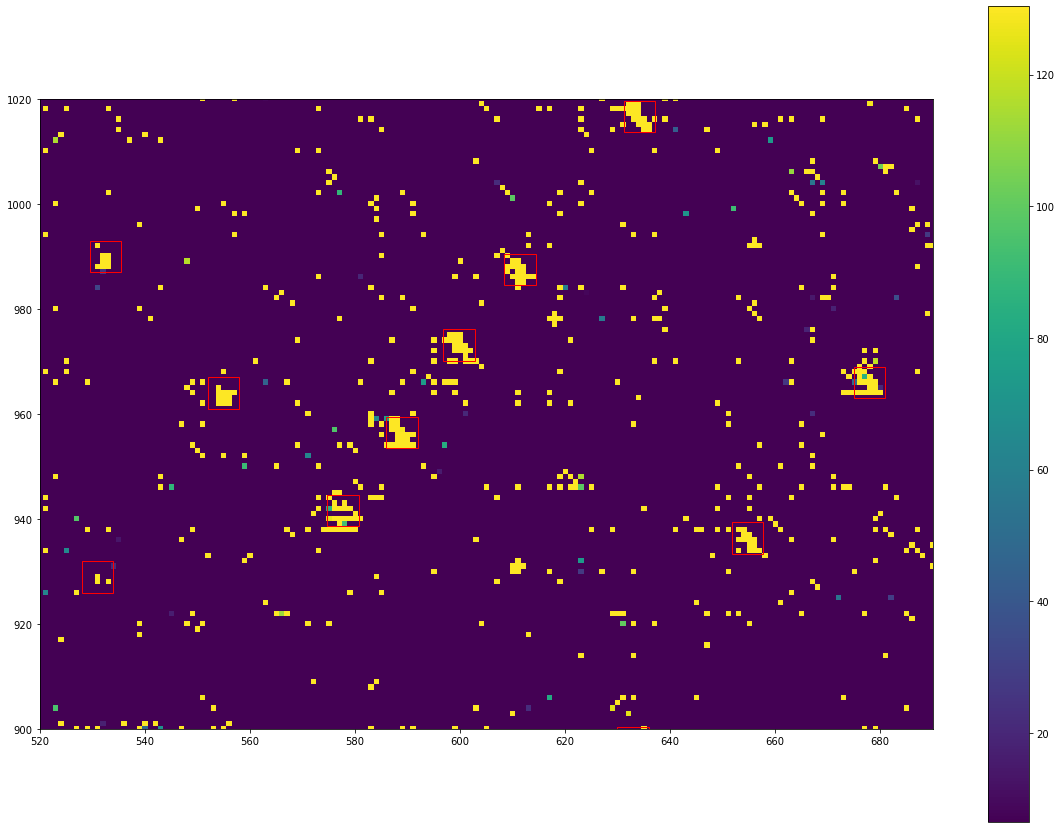

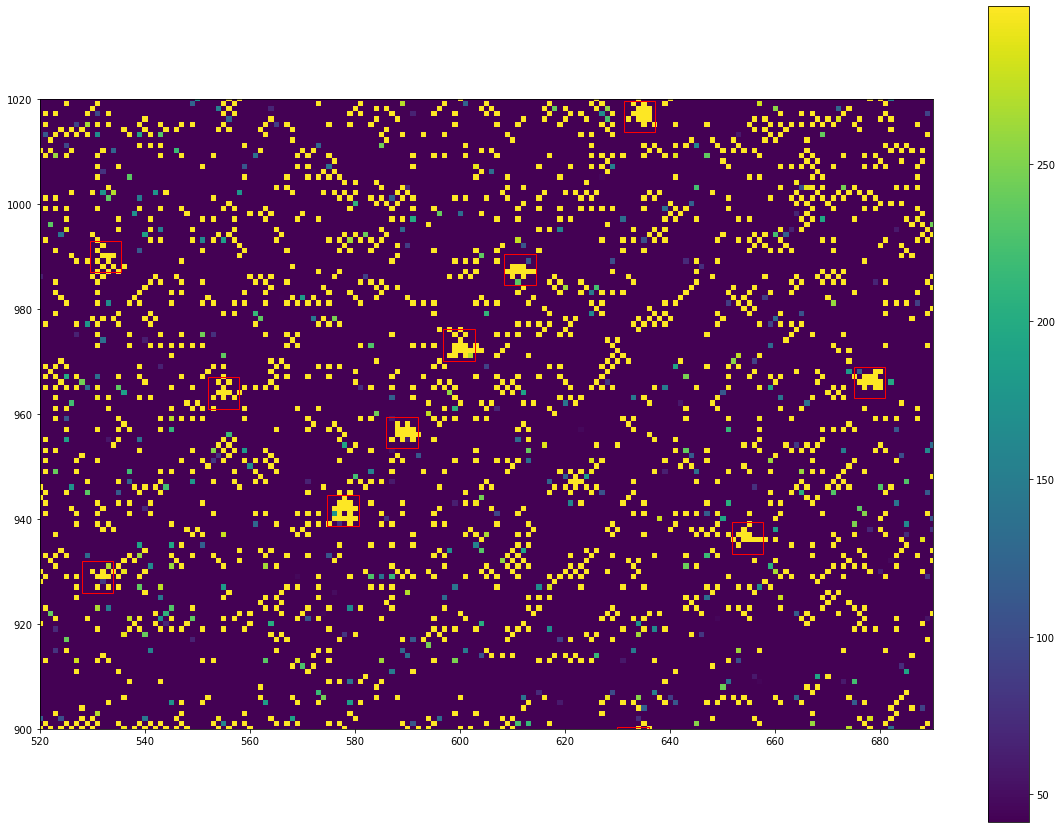

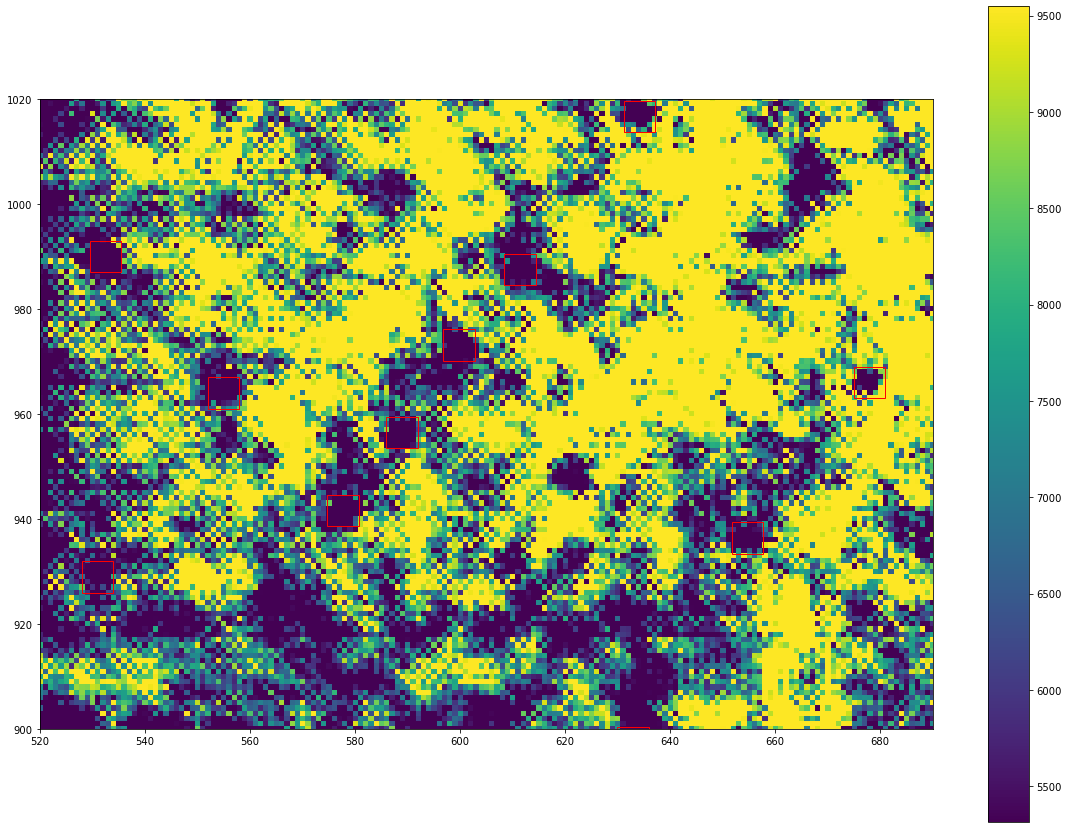

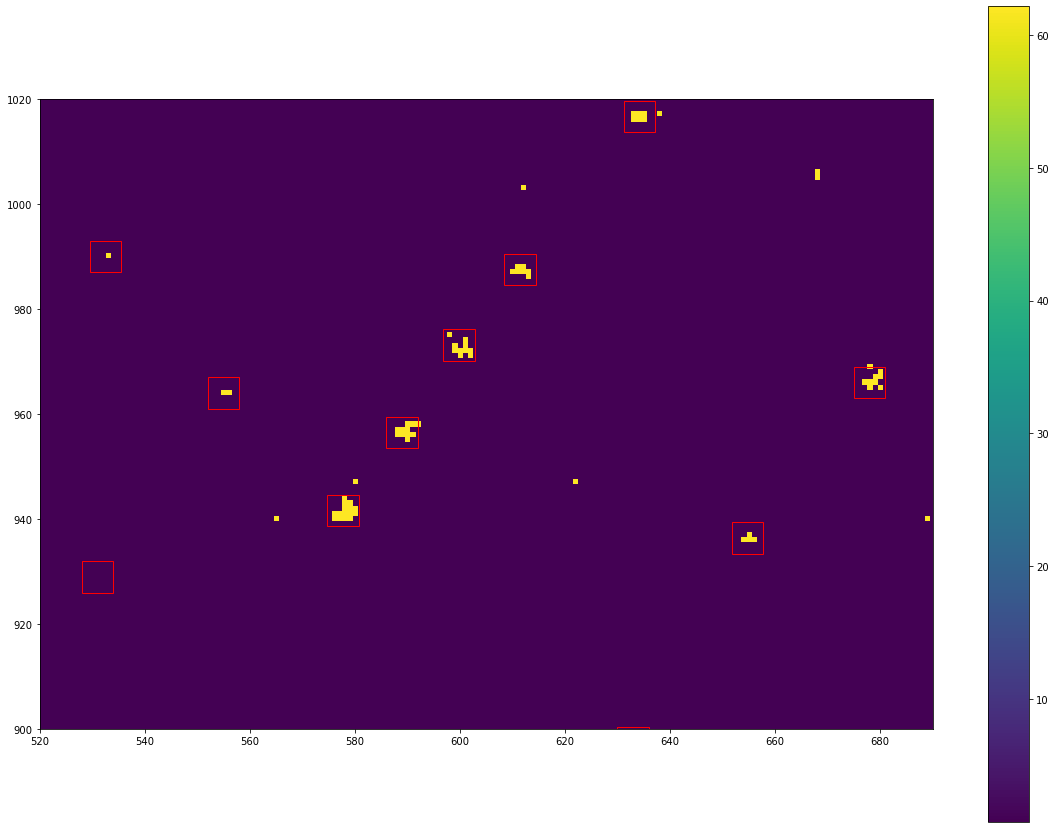

In [253]:
for i in range(len(preamap[0][0])):
    fig  = plt.figure(figsize=(20,15))
    data = preamap[0][0, i].cpu().detach().numpy()
    vmin = data.mean()
    vmax = vmin + 1 * data.std()
    # data = data[900:1020, 520:690]
    plt.imshow(data, vmin = vmin, vmax = vmax)
    plt.colorbar()

    # Add box
    offset = 3
    linewidth = 1
    for y, x in peak_pos_list:
        if np.isnan(y) or np.isnan(x): continue

        x_bottom_left = x - offset
        y_bottom_left = y - offset

        ## x_bottom_left += 2
        ## y_bottom_left += 1

        rec_obj = mpatches.Rectangle((x_bottom_left, y_bottom_left), 
                                     2 * offset, 2 * offset, 
                                     linewidth = linewidth, 
                                     edgecolor = 'red', 
                                     facecolor='none')
        fig.gca().add_patch(rec_obj)
    plt.xlim(520,690)
    plt.ylim(900,1020)